In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score 

dfData = pd.read_csv('train.csv')

dfData1 = dfData[['ID','Age','Num_Bank_Accounts','Credit_Score','Annual_Income','Occupation','Payment_Behaviour']].copy()

/tmp/ipykernel_733/3633746658.py:6: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  dfData = pd.read_csv('train.csv')


In [196]:
dfData1['nCuentas'] = dfData1['Num_Bank_Accounts']
dfData1.loc[dfData1['nCuentas']<0,'nCuentas'] = 0
dfData1.loc[dfData1['nCuentas']>=8,'nCuentas'] = 8

dfData1['Annual_Income'] = dfData1['Annual_Income'].str.replace('_','')
dfData1['Annual_Income'] = pd.to_numeric(dfData1['Annual_Income'],errors='coerce')
dfData1['Annual_Income'].isna().sum()

dfData1['Occupation'] = dfData1['Occupation'].str.replace('_______','Desconocido')
dfData1['Payment_Behaviour'] = dfData1['Payment_Behaviour'].str.replace('!@9#%8','Desconocido')

dfData1['Edad'] = dfData1['Age'].str.replace('_','')
dfData1['Edad'] = pd.to_numeric(dfData1['Edad'],errors='coerce')

dfData1 = dfData1.loc[(dfData1['Edad']<=90)&(dfData1['Edad']>=18),:].copy()



In [198]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [200]:
dfData2, df_test = train_test_split(dfData1, test_size = 0.25, random_state=42)

## Variable dependiente

In [203]:
dfData1['Credit_Score'].unique()
dfData1['Credit_Score'].value_counts()
dfData1['malo']=dfData1['Credit_Score'].map({'Good':0, 'Standard':0, 'Poor':1})
dfData1['malo'].value_counts()

malo
0    65873
1    25640
Name: count, dtype: int64

In [205]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

dfData2, df_test = train_test_split(dfData1, test_size = 0.25, random_state=42)

## Variables independientes: Número de cuentas bancarias

In [208]:
dfDMalo = dfData2[['nCuentas','malo']]
dfCountBankAcc=dfData2['nCuentas'].value_counts().sort_index()
dfCountBankAcc


nCuentas
0     3139
1     3258
2     3136
3     8406
4     8503
5     8463
6     8702
7     8604
8    16423
Name: count, dtype: int64

In [210]:
dfTablaWoeNumCuentas = dfData2[['nCuentas','malo']].groupby('nCuentas').agg({'malo':['sum','count']})
dfTablaWoeNumCuentas = dfDMalo.groupby('nCuentas').agg({'malo':['sum','count']})
dfTablaWoeNumCuentas.columns = ['malo','total']
dfTablaWoeNumCuentas['probMalo'] = dfTablaWoeNumCuentas['malo'] / dfTablaWoeNumCuentas['total']
dfTablaWoeNumCuentas


,malo,total,probMalo
nCuentas,,,
0,551,3139,0.175534
1,511,3258,0.156845
2,437,3136,0.139349
3,1286,8406,0.152986
4,1312,8503,0.154298
5,1339,8463,0.158218
6,3052,8702,0.350724
7,3093,8604,0.359484
8,7576,16423,0.461304


In [212]:
dfTablaWoeNumCuentas['bueno'] = dfTablaWoeNumCuentas['total']-dfTablaWoeNumCuentas['malo']
dfTablaWoeNumCuentas['distBad'] = dfTablaWoeNumCuentas['malo'] / dfTablaWoeNumCuentas['malo'].sum() 
dfTablaWoeNumCuentas['distGood'] = dfTablaWoeNumCuentas['bueno'] / dfTablaWoeNumCuentas['bueno'].sum()
dfTablaWoeNumCuentas['woe_NumCuentas'] = np.log(dfTablaWoeNumCuentas['distBad']/dfTablaWoeNumCuentas['distGood'])

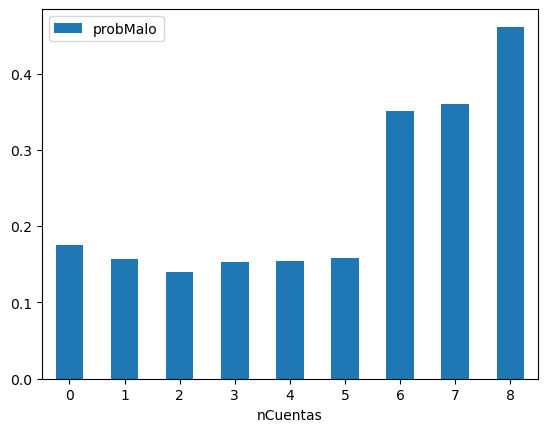

In [214]:
ax = dfTablaWoeNumCuentas.plot.bar(y='probMalo', rot=0)

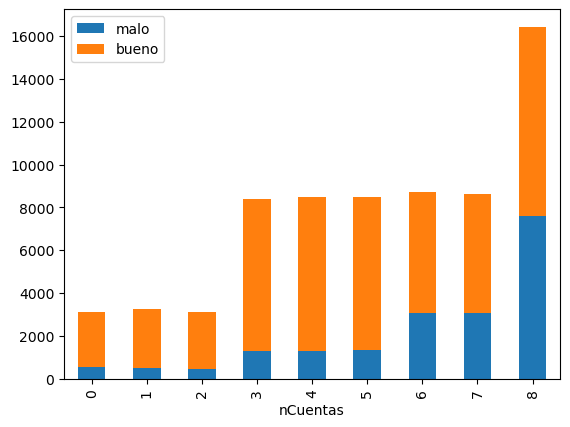

In [215]:
ax = dfTablaWoeNumCuentas[['malo','bueno']].plot.bar(stacked=True)

In [218]:
information_value = (dfTablaWoeNumCuentas['woe_NumCuentas'] *(dfTablaWoeNumCuentas['distBad'] -dfTablaWoeNumCuentas['distGood'] )).sum()
information_value

0.4384005356422427

In [220]:
contingencia = dfTablaWoeNumCuentas[['malo','bueno']]
contingencia

,malo,bueno
nCuentas,,
0,551,2588
1,511,2747
2,437,2699
3,1286,7120
4,1312,7191
5,1339,7124
6,3052,5650
7,3093,5511
8,7576,8847


In [224]:
from scipy.stats import chi2_contingency
res = chi2_contingency(contingencia.transpose())
res



Chi2ContingencyResult(statistic=5858.831920519471, pvalue=0.0, dof=8, expected_freq=array([[  876.15209663,   909.36716496,   875.31474196,  2346.26776816,
         2373.34223563,  2362.17750678,  2428.88676166,  2401.53317598,
         4583.95854824],
       [ 2262.84790337,  2348.63283504,  2260.68525804,  6059.73223184,
         6129.65776437,  6100.82249322,  6273.11323834,  6202.46682402,
        11839.04145176]]))

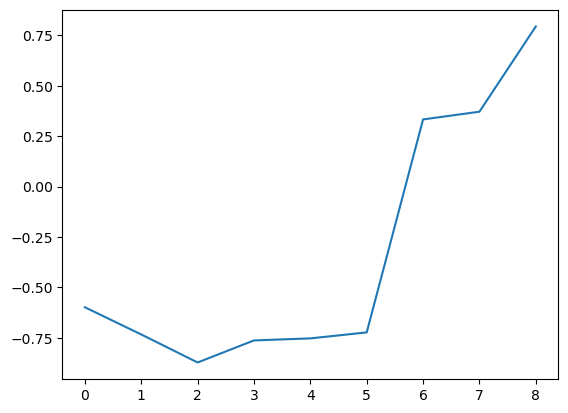

In [226]:
dfTablaWoeNumCuentas.reset_index(inplace=True)
plt.plot(dfTablaWoeNumCuentas['woe_NumCuentas'])

In [230]:
dfData2 = pd.merge(dfData2,dfTablaWoeNumCuentas[['nCuentas','woe_NumCuentas']],on='nCuentas')
dfData2

,ID,Age,Num_Bank_Accounts,Credit_Score,Annual_Income,Occupation,Payment_Behaviour,nCuentas,Edad,malo,woe_NumCuentas
0,0x1fc5b,36,3,Standard,50473.800,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531
1,0x107e2,49,3,Standard,20194.020,Mechanic,Low_spent_Small_value_payments,3,49,0,-0.762531
2,0x24c42,41,3,Poor,46360.110,Media_Manager,Low_spent_Small_value_payments,3,41,1,-0.762531
3,0x12c30,20,3,Good,16038.680,Scientist,Low_spent_Medium_value_payments,3,20,0,-0.762531
4,0x2475,34,3,Standard,15735.680,Entrepreneur,Low_spent_Small_value_payments,3,34,0,-0.762531
...,...,...,...,...,...,...,...,...,...,...,...
68629,0x15d63,27,2,Standard,87416.520,Entrepreneur,High_spent_Large_value_payments,2,27,0,-0.871864
68630,0x51a5,52,2,Standard,20145.525,Teacher,High_spent_Medium_value_payments,2,52,0,-0.871864
68631,0xb1cb,32,2,Good,169229.440,Developer,High_spent_Small_value_payments,2,32,0,-0.871864
68632,0x5a54,36,2,Standard,94934.940,Manager,Desconocido,2,36,0,-0.871864


## Variables independientes: Edad

In [233]:
dfData2['EdadCat'], binsEdad = pd.cut(dfData2['Edad'],bins = 5, retbins=True )
dfData2['EdadCat'].value_counts()

dfTablaWoeEdad = dfData2[['EdadCat','malo']].groupby('EdadCat').agg({'malo':['sum','count']})
dfTablaWoeEdad.columns = ['malo','total']
dfTablaWoeEdad['probMalo'] = dfTablaWoeEdad['malo'] / dfTablaWoeEdad['total']
dfTablaWoeEdad

/tmp/ipykernel_733/901936285.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfTablaWoeEdad = dfData2[['EdadCat','malo']].groupby('EdadCat').agg({'malo':['sum','count']})


,malo,total,probMalo
EdadCat,,,
"(17.962, 25.6]",4971,16277,0.305400
"(25.6, 33.2]",5244,16904,0.310222
"(33.2, 40.8]",4544,14813,0.306758
"(40.8, 48.4]",3589,13337,0.269101
"(48.4, 56.0]",809,7303,0.110776


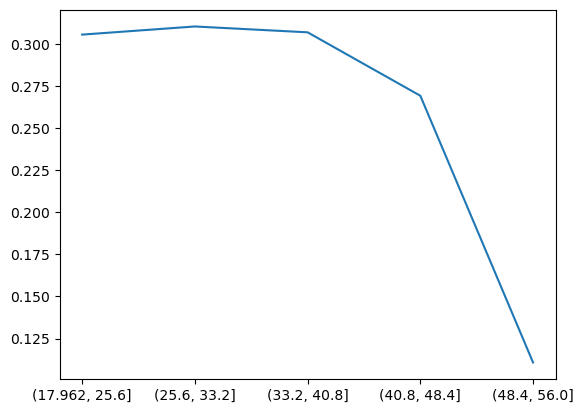

In [234]:
dfTablaWoeEdad.index = dfTablaWoeEdad.index.astype(str)
plt.plot(dfTablaWoeEdad['probMalo'])

In [239]:
dfCountEdadCat=dfData2['EdadCat'].value_counts().sort_index()
dfCountEdadCat

EdadCat
(17.962, 25.6]    16277
(25.6, 33.2]      16904
(33.2, 40.8]      14813
(40.8, 48.4]      13337
(48.4, 56.0]       7303
Name: count, dtype: int64

In [241]:
dfTablaWoeEdad['bueno'] = dfTablaWoeEdad['total']-dfTablaWoeEdad['malo']
dfTablaWoeEdad['distBad'] = dfTablaWoeEdad['malo'] / dfTablaWoeEdad['malo'].sum() 
dfTablaWoeEdad['distGood'] = dfTablaWoeEdad['bueno'] / dfTablaWoeEdad['bueno'].sum()
dfTablaWoeEdad['woe_edad'] = np.log(dfTablaWoeEdad['distBad']/dfTablaWoeEdad['distGood'])

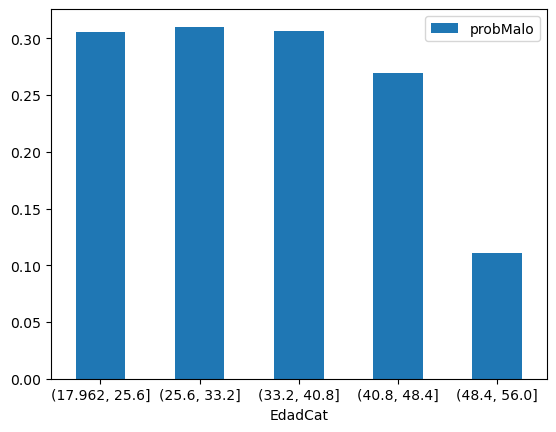

In [243]:
ax = dfTablaWoeEdad.plot.bar(y='probMalo', rot=0)

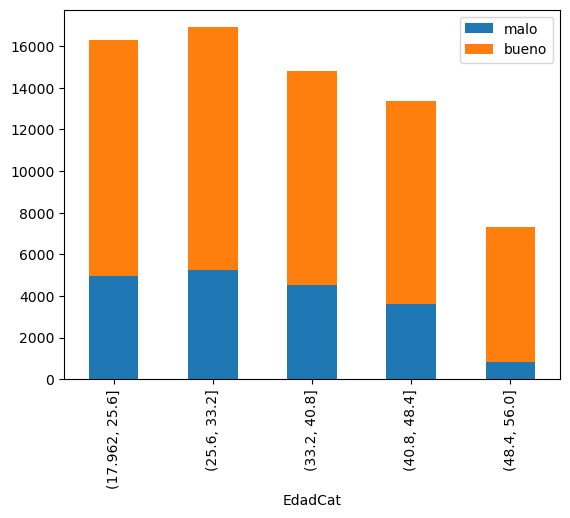

In [245]:
ax = dfTablaWoeEdad[['malo','bueno']].plot.bar(stacked=True)

In [247]:
information_value = (dfTablaWoeEdad['woe_edad'] *(dfTablaWoeEdad['distBad'] -dfTablaWoeEdad['distGood'] )).sum()
information_value

0.1150368942076775

In [249]:
contingencia = dfTablaWoeEdad[['malo','bueno']]
res = chi2_contingency(contingencia.transpose())



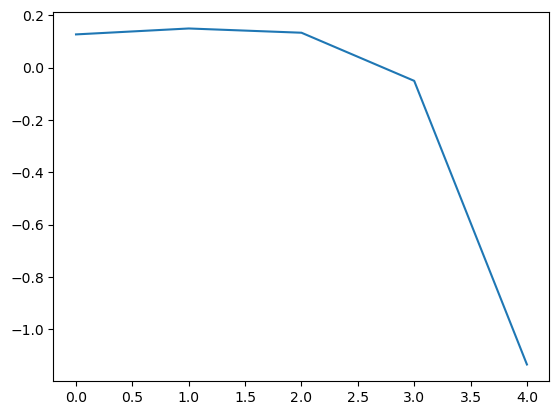

In [251]:
dfTablaWoeEdad.reset_index(inplace=True)
plt.plot(dfTablaWoeEdad['woe_edad'])

In [253]:
dfData2['EdadCat'] = dfData2['EdadCat'].astype(str)
dfData2 = pd.merge(dfData2,dfTablaWoeEdad[['EdadCat','woe_edad']],on='EdadCat')
dfData2

,ID,Age,Num_Bank_Accounts,Credit_Score,Annual_Income,Occupation,Payment_Behaviour,nCuentas,Edad,malo,woe_NumCuentas,EdadCat,woe_edad
0,0x1fc5b,36,3,Standard,50473.80,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531,"(33.2, 40.8]",0.133518
1,0x2475,34,3,Standard,15735.68,Entrepreneur,Low_spent_Small_value_payments,3,34,0,-0.762531,"(33.2, 40.8]",0.133518
2,0x176e9,34,3,Standard,20653.25,Entrepreneur,High_spent_Small_value_payments,3,34,0,-0.762531,"(33.2, 40.8]",0.133518
3,0x198c6,35,3,Standard,57353.16,Writer,Desconocido,3,35,0,-0.762531,"(33.2, 40.8]",0.133518
4,0xf380,35,3,Good,30371.74,Architect,Low_spent_Small_value_payments,3,35,0,-0.762531,"(33.2, 40.8]",0.133518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68629,0x173fe,28,2,Good,44986.31,Journalist,Low_spent_Large_value_payments,2,28,0,-0.871864,"(25.6, 33.2]",0.149760
68630,0x2354a,27,2,Standard,20975.40,Media_Manager,Low_spent_Small_value_payments,2,27,0,-0.871864,"(25.6, 33.2]",0.149760
68631,0x5f28,29,2,Standard,20000.41,Writer,Low_spent_Large_value_payments,2,29,0,-0.871864,"(25.6, 33.2]",0.149760
68632,0x15d63,27,2,Standard,87416.52,Entrepreneur,High_spent_Large_value_payments,2,27,0,-0.871864,"(25.6, 33.2]",0.149760


## Variables independientes: Ingreso Anual

In [269]:
cuantial_al_10 = dfData2['Annual_Income'].quantile(.10)
cuantil_al_90 = dfData2['Annual_Income'].quantile(.90)
dfData2 = dfData2.loc[(dfData2['Annual_Income']<=cuantil_al_90)&(dfData2['Annual_Income']>=cuantial_al_10),:].copy()

dfData2['Annual_IncomeCat'], binsAnIn = pd.cut(dfData2['Annual_Income'],bins = 5, retbins=True)
dfData2['Annual_IncomeCat'].value_counts()


Annual_IncomeCat
(14277.62, 34502.32]     24181
(34502.32, 54626.4]      11350
(54626.4, 74750.48]       9484
(74750.48, 94874.56]      5990
(94874.56, 114998.64]     3910
Name: count, dtype: int64

In [272]:
dfTablaWoeIngresoAn = dfData2[['Annual_IncomeCat','malo']].groupby('Annual_IncomeCat').agg({'malo':['sum','count']})
dfTablaWoeIngresoAn.columns = ['malo','total']
dfTablaWoeIngresoAn['probMalo'] = dfTablaWoeIngresoAn['malo'] / dfTablaWoeIngresoAn['total']
dfTablaWoeIngresoAn


/tmp/ipykernel_733/589904706.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfTablaWoeIngresoAn = dfData2[['Annual_IncomeCat','malo']].groupby('Annual_IncomeCat').agg({'malo':['sum','count']})


,malo,total,probMalo
Annual_IncomeCat,,,
"(14277.62, 34502.32]",7325,24181,0.302924
"(34502.32, 54626.4]",3442,11350,0.303260
"(54626.4, 74750.48]",2813,9484,0.296605
"(74750.48, 94874.56]",1233,5990,0.205843
"(94874.56, 114998.64]",435,3910,0.111253


In [275]:
dfTablaWoeIngresoAn.index = dfTablaWoeIngresoAn.index.astype(str)

In [277]:
dfCountAnnual_IncomeCat=dfData2['Annual_IncomeCat'].value_counts().sort_index()
dfCountAnnual_IncomeCat

Annual_IncomeCat
(14277.62, 34502.32]     24181
(34502.32, 54626.4]      11350
(54626.4, 74750.48]       9484
(74750.48, 94874.56]      5990
(94874.56, 114998.64]     3910
Name: count, dtype: int64

In [279]:
dfTablaWoeIngresoAn['bueno'] = dfTablaWoeIngresoAn['total']-dfTablaWoeIngresoAn['malo']
dfTablaWoeIngresoAn['distBad'] = dfTablaWoeIngresoAn['malo'] / dfTablaWoeIngresoAn['malo'].sum() 
dfTablaWoeIngresoAn['distGood'] = dfTablaWoeIngresoAn['bueno'] / dfTablaWoeIngresoAn['bueno'].sum()
dfTablaWoeIngresoAn['woe_IngAn'] = np.log(dfTablaWoeIngresoAn['distBad']/dfTablaWoeIngresoAn['distGood'])

<Axes: >

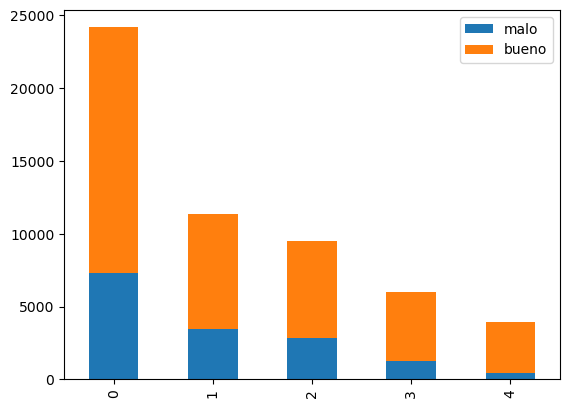

In [343]:
dfTablaWoeIngresoAn[['malo','bueno']].plot.bar(stacked=True)


In [283]:
information_value_IngreAnual = (dfTablaWoeIngresoAn['woe_IngAn'] *(dfTablaWoeIngresoAn['distBad'] -dfTablaWoeIngresoAn['distGood'] )).sum()
information_value_IngreAnual

0.09326094175705568

In [348]:
contingencia_AnIn = dfTablaWoeIngresoAn[['malo','bueno']]
contingencia_AnIn

,malo,bueno
0,7325,16856
1,3442,7908
2,2813,6671
3,1233,4757
4,435,3475


In [288]:
res_IngreAnual = chi2_contingency(contingencia_AnIn)
res_IngreAnual

Chi2ContingencyResult(statistic=824.8750662958078, pvalue=3.140979665141707e-177, dof=4, expected_freq=array([[ 6714.22904489, 17466.77095511],
       [ 3151.50323227,  8198.49676773],
       [ 2633.37944095,  6850.62055905],
       [ 1663.21624329,  4326.78375671],
       [ 1085.67203861,  2824.32796139]]))

In [292]:
dfTablaWoeIngresoAn.reset_index(inplace=True)
dfData2['Annual_IncomeCat'] = dfData2['Annual_IncomeCat'].astype(str)

In [294]:
dfData2 = pd.merge(dfData2,dfTablaWoeIngresoAn[['Annual_IncomeCat','woe_IngAn']],on='Annual_IncomeCat')

In [296]:
dfData2['Annual_IncomeCat'].value_counts()

Annual_IncomeCat
(14277.62, 34502.32]     24181
(34502.32, 54626.4]      11350
(54626.4, 74750.48]       9484
(74750.48, 94874.56]      5990
(94874.56, 114998.64]     3910
Name: count, dtype: int64

## Variable independiente: Occupation

In [300]:
dfTablaWoeOcup = dfData2[['Occupation','malo']].groupby('Occupation').agg({'malo':['sum','count']})
dfTablaWoeOcup.columns = ['malo','total']
dfTablaWoeOcup['probMalo'] = dfTablaWoeOcup['malo'] / dfTablaWoeOcup['total']

dfTablaWoeOcup['bueno'] = dfTablaWoeOcup['total']-dfTablaWoeOcup['malo']
dfTablaWoeOcup['distBad'] = dfTablaWoeOcup['malo'] / dfTablaWoeOcup['malo'].sum() 
dfTablaWoeOcup['distGood'] = dfTablaWoeOcup['bueno'] / dfTablaWoeOcup['bueno'].sum()
dfTablaWoeOcup['woe_occupation'] = np.log(dfTablaWoeOcup['distBad']/dfTablaWoeOcup['distGood'])
dfTablaWoeOcup

,malo,total,probMalo,bueno,distBad,distGood,woe_occupation
Occupation,,,,,,,
Accountant,947,3358,0.282013,2411,0.062107,0.060781,0.021573
Architect,943,3441,0.274048,2498,0.061844,0.062974,-0.018108
Desconocido,1080,3877,0.278566,2797,0.070829,0.070512,0.004485
Developer,962,3289,0.292490,2327,0.063090,0.058663,0.072751
Doctor,860,3337,0.257717,2477,0.056401,0.062445,-0.101800
Engineer,1020,3521,0.289690,2501,0.066894,0.063050,0.059183
Entrepreneur,1000,3538,0.282646,2538,0.065582,0.063983,0.024695
Journalist,912,3435,0.265502,2523,0.059811,0.063605,-0.061493
Lawyer,954,3730,0.255764,2776,0.062566,0.069983,-0.112031


In [302]:
dfTablaWoeOcup.reset_index(inplace=True)
dfTablaWoeOcup.index = dfTablaWoeOcup.index.astype(str)
dfData2['Occupation'] = dfData2['Occupation'].astype(str)
dfData2 = pd.merge(dfData2,dfTablaWoeOcup[['Occupation','woe_occupation']],on='Occupation')

## Variable independiente: Payment Behaviour

In [306]:
dfCountPayBeh = dfData2['Payment_Behaviour'].value_counts().sort_index()


In [308]:
dfTablaWoeCompPagos = dfData2[['Payment_Behaviour','malo']].groupby('Payment_Behaviour').agg({'malo':['sum','count']})
dfTablaWoeCompPagos.columns = ['malo','total']
dfTablaWoeCompPagos['probMalo'] = dfTablaWoeCompPagos['malo'] / dfTablaWoeCompPagos['total']

dfTablaWoeCompPagos['bueno'] = dfTablaWoeCompPagos['total']-dfTablaWoeCompPagos['malo']
dfTablaWoeCompPagos['distBad'] = dfTablaWoeCompPagos['malo'] / dfTablaWoeCompPagos['malo'].sum() 
dfTablaWoeCompPagos['distGood'] = dfTablaWoeCompPagos['bueno'] / dfTablaWoeCompPagos['bueno'].sum()
dfTablaWoeCompPagos['woe_CompPagos'] = np.log(dfTablaWoeCompPagos['distBad']/dfTablaWoeCompPagos['distGood'])
dfTablaWoeCompPagos

,malo,total,probMalo,bueno,distBad,distGood,woe_CompPagos
Payment_Behaviour,,,,,,,
Desconocido,1149,4141,0.277469,2992,0.075354,0.075428,-0.000979
High_spent_Large_value_payments,1697,7483,0.226781,5786,0.111293,0.145864,-0.270508
High_spent_Medium_value_payments,2604,10441,0.249401,7837,0.170776,0.197570,-0.145736
High_spent_Small_value_payments,1693,6479,0.261306,4786,0.111031,0.120654,-0.083122
Low_spent_Large_value_payments,1620,6009,0.269596,4389,0.106243,0.110646,-0.040604
Low_spent_Medium_value_payments,2076,6971,0.297805,4895,0.136149,0.123402,0.098300
Low_spent_Small_value_payments,4409,13391,0.329251,8982,0.289153,0.226435,0.244497


In [310]:
dfTablaWoeCompPagos['malo'].sort_index()

Payment_Behaviour
Desconocido                         1149
High_spent_Large_value_payments     1697
High_spent_Medium_value_payments    2604
High_spent_Small_value_payments     1693
Low_spent_Large_value_payments      1620
Low_spent_Medium_value_payments     2076
Low_spent_Small_value_payments      4409
Name: malo, dtype: int64

In [312]:
dfTablaWoeCompPagos['probMalo'].sort_index()

Payment_Behaviour
Desconocido                         0.277469
High_spent_Large_value_payments     0.226781
High_spent_Medium_value_payments    0.249401
High_spent_Small_value_payments     0.261306
Low_spent_Large_value_payments      0.269596
Low_spent_Medium_value_payments     0.297805
Low_spent_Small_value_payments      0.329251
Name: probMalo, dtype: float64

In [314]:
dfTablaWoeCompPagos.reset_index(inplace=True)
dfTablaWoeCompPagos.index = dfTablaWoeCompPagos.index.astype(str)
dfData2['Payment_Behaviour'] = dfData2['Payment_Behaviour'].astype(str)
dfData2 = pd.merge(dfData2,dfTablaWoeCompPagos[['Payment_Behaviour','woe_CompPagos']],on='Payment_Behaviour')


In [326]:
dfData2

,ID,Age,Num_Bank_Accounts,Credit_Score,Annual_Income,Occupation,Payment_Behaviour,nCuentas,Edad,malo,woe_NumCuentas,EdadCat,woe_edad,Annual_IncomeCat,woe_IngAn,woe_occupation,woe_CompPagos
0,0x1fc5b,36,3,Standard,50473.80,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
1,0x1fc57,36,3,Poor,50473.80,Teacher,Low_spent_Small_value_payments,3,36,1,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
2,0x1fc56,36,3,Standard,50473.80,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
3,0x1fd63,37,7,Poor,51433.89,Teacher,Low_spent_Small_value_payments,7,37,1,0.371235,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
4,0x4d7c,37,7,Standard,42052.74,Teacher,Low_spent_Small_value_payments,7,37,0,0.371235,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54910,0x65f5,33,4,Good,90664.48,Scientist,Low_spent_Medium_value_payments,4,33,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54911,0x834d,26,4,Standard,74837.12,Scientist,Low_spent_Medium_value_payments,4,26,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54912,0x17992,29,4,Standard,90541.71,Scientist,Low_spent_Medium_value_payments,4,29,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54913,0x1239c,29,4,Poor,87902.13,Scientist,Low_spent_Medium_value_payments,4,29,1,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300


## Análisis de correlación entre variables

In [381]:
import seaborn as sns

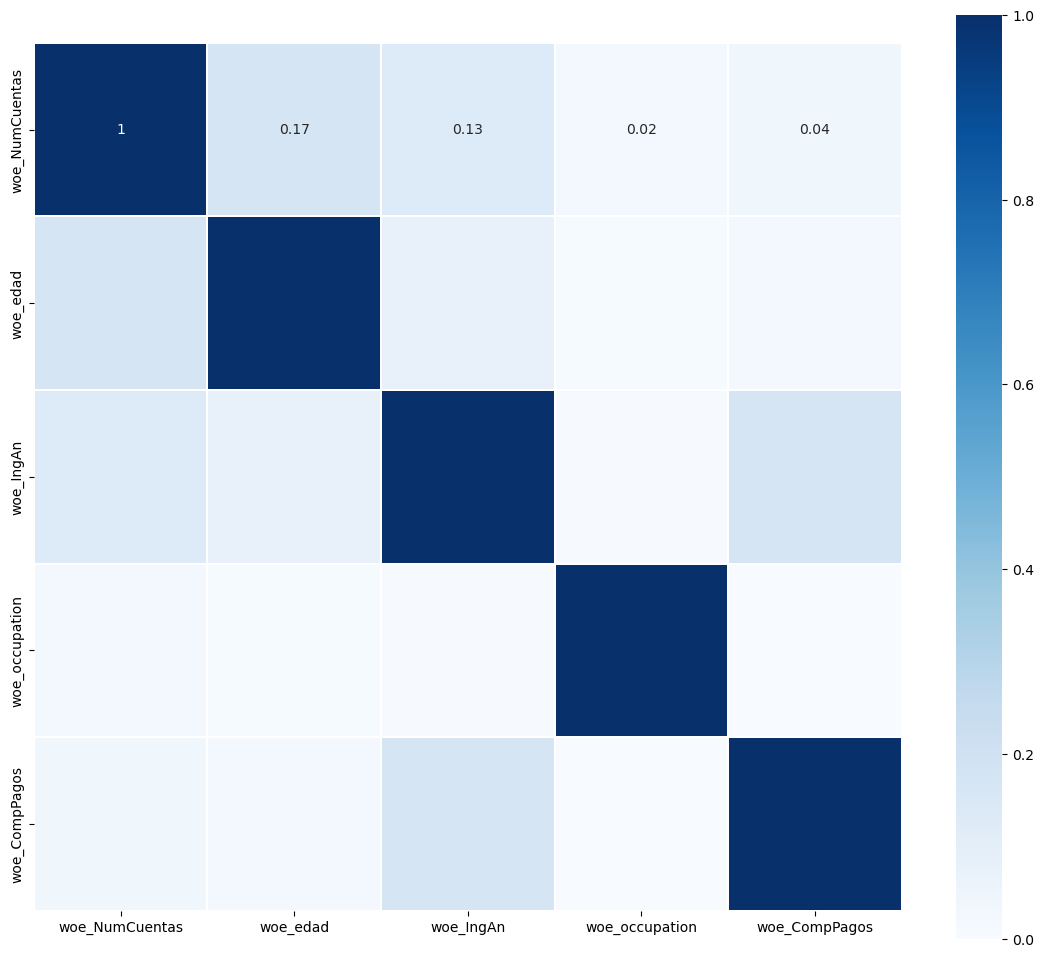

In [386]:
plt.figure(figsize=(14,12))

sns.heatmap(dfData2[['woe_NumCuentas', 'woe_edad', 'woe_IngAn', 'woe_occupation', 'woe_CompPagos']].corr(),
            linewidths=0.1, vmax=1.0, square=True, linecolor='white', annot=True, cmap='Blues')
plt.show()

In [392]:
 dfData2[['woe_NumCuentas', 'woe_edad', 'woe_IngAn', 'woe_occupation', 'woe_CompPagos']].corr()

,woe_NumCuentas,woe_edad,woe_IngAn,woe_occupation,woe_CompPagos
woe_NumCuentas,1.000000,0.171185,0.132104,0.019859,0.039958
woe_edad,0.171185,1.000000,0.075175,0.007886,0.021355
woe_IngAn,0.132104,0.075175,1.000000,0.004945,0.167832
woe_occupation,0.019859,0.007886,0.004945,1.000000,-0.000282
woe_CompPagos,0.039958,0.021355,0.167832,-0.000282,1.000000


# Modelo con validación

In [395]:
import statsmodels.formula.api as smf
model_train = smf.logit('malo ~ woe_NumCuentas + woe_edad + woe_IngAn + woe_occupation + woe_CompPagos', data= dfData2).fit()
print(model_train.summary())

Optimization terminated successfully.
         Current function value: 0.536000
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   malo   No. Observations:                54915
Model:                          Logit   Df Residuals:                    54909
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                 0.09266
Time:                        16:34:47   Log-Likelihood:                -29434.
converged:                       True   LL-Null:                       -32440.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9649      0.010    -93.898      0.000      -0.985      -0.945
woe_NumCuentas   

In [396]:
model_train.predict()

array([0.21773821, 0.21773821, 0.21773821, ..., 0.15505917, 0.15505917,
       0.15505917])

In [399]:
len(model_train.predict())

54915

In [401]:
dfData2

,ID,Age,Num_Bank_Accounts,Credit_Score,Annual_Income,Occupation,Payment_Behaviour,nCuentas,Edad,malo,woe_NumCuentas,EdadCat,woe_edad,Annual_IncomeCat,woe_IngAn,woe_occupation,woe_CompPagos
0,0x1fc5b,36,3,Standard,50473.80,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
1,0x1fc57,36,3,Poor,50473.80,Teacher,Low_spent_Small_value_payments,3,36,1,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
2,0x1fc56,36,3,Standard,50473.80,Teacher,Low_spent_Small_value_payments,3,36,0,-0.762531,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
3,0x1fd63,37,7,Poor,51433.89,Teacher,Low_spent_Small_value_payments,7,37,1,0.371235,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
4,0x4d7c,37,7,Standard,42052.74,Teacher,Low_spent_Small_value_payments,7,37,0,0.371235,"(33.2, 40.8]",0.133518,"(34502.32, 54626.4]",0.124249,0.031249,0.244497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54910,0x65f5,33,4,Good,90664.48,Scientist,Low_spent_Medium_value_payments,4,33,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54911,0x834d,26,4,Standard,74837.12,Scientist,Low_spent_Medium_value_payments,4,26,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54912,0x17992,29,4,Standard,90541.71,Scientist,Low_spent_Medium_value_payments,4,29,0,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300
54913,0x1239c,29,4,Poor,87902.13,Scientist,Low_spent_Medium_value_payments,4,29,1,-0.752438,"(25.6, 33.2]",0.149760,"(74750.48, 94874.56]",-0.394096,0.060687,0.098300


In [413]:
df_test.loc[df_test['nCuentas']>=8,'nCuentas'] = 8
df_test = pd.merge(df_test,dfTablaWoeNumCuentas[['nCuentas','woe_NumCuentas']],on='nCuentas')

df_test['EdadCat'] = pd.cut(df_test['Edad'], bins=binsEdad, right=True)
df_test['EdadCat'] = df_test['EdadCat'].astype(str)
df_test = pd.merge(df_test,dfTablaWoeEdad[['EdadCat','woe_edad']],on='EdadCat')

df_test['Annual_IncomeCat'] = pd.cut(df_test['Annual_Income'], bins=binsAnIn, right=True)
df_test['Annual_IncomeCat'] = df_test['Annual_IncomeCat'].astype(str)
df_test = pd.merge(df_test,dfTablaWoeIngresoAn[['Annual_IncomeCat','woe_IngAn']],on='Annual_IncomeCat')

df_test['Occupation'] = df_test['Occupation'].astype(str)
df_test = pd.merge(df_test,dfTablaWoeOcup[['Occupation','woe_occupation']],on='Occupation')

df_test['Payment_Behaviour'] = df_test['Payment_Behaviour'].astype(str)
df_test = pd.merge(df_test,dfTablaWoeCompPagos[['Payment_Behaviour','woe_CompPagos']],on='Payment_Behaviour')

df_test

,ID,Age,Num_Bank_Accounts,Credit_Score,Annual_Income,Occupation,Payment_Behaviour,nCuentas,Edad,malo,...,woe_NumCuentas_y,woe_edad_y,woe_IngAn_y,woe_occupation_y,woe_CompPagos_y,woe_NumCuentas,woe_edad,woe_IngAn,woe_occupation,woe_CompPagos
0,0xfe61,42,1,Standard,85494.50,Scientist,Low_spent_Medium_value_payments,1,42,0,...,-0.733055,-0.050349,-0.394096,0.060687,0.098300,-0.733055,-0.050349,-0.394096,0.060687,0.098300
1,0x12cef,44,8,Standard,80370.32,Scientist,Low_spent_Medium_value_payments,8,44,0,...,0.793747,-0.050349,-0.394096,0.060687,0.098300,0.793747,-0.050349,-0.394096,0.060687,0.098300
2,0x1e834,45,10,Poor,80377.68,Scientist,Low_spent_Medium_value_payments,8,45,1,...,0.793747,-0.050349,-0.394096,0.060687,0.098300,0.793747,-0.050349,-0.394096,0.060687,0.098300
3,0x867a,44,5,Standard,91869.45,Scientist,Low_spent_Medium_value_payments,5,44,0,...,-0.722707,-0.050349,-0.394096,0.060687,0.098300,-0.722707,-0.050349,-0.394096,0.060687,0.098300
4,0x1e606,41,5,Standard,86415.56,Scientist,Low_spent_Medium_value_payments,5,41,0,...,-0.722707,-0.050349,-0.394096,0.060687,0.098300,-0.722707,-0.050349,-0.394096,0.060687,0.098300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18455,0x899b,54,7,Standard,105667.62,Manager,Desconocido,7,54,0,...,0.371235,-1.133995,-1.121932,0.018815,-0.000979,0.371235,-1.133995,-1.121932,0.018815,-0.000979
18456,0x899c,55,7,Standard,105667.62,Manager,Desconocido,7,55,0,...,0.371235,-1.133995,-1.121932,0.018815,-0.000979,0.371235,-1.133995,-1.121932,0.018815,-0.000979
18457,0xb3d8,38,1,Standard,99845.40,Manager,Desconocido,1,38,0,...,-0.733055,0.133518,-1.121932,0.018815,-0.000979,-0.733055,0.133518,-1.121932,0.018815,-0.000979
18458,0x1040a,35,6,Standard,102343.68,Manager,Desconocido,6,35,0,...,0.332981,0.133518,-1.121932,0.018815,-0.000979,0.332981,0.133518,-1.121932,0.018815,-0.000979


In [405]:
corte = .3

In [417]:
y_pred = model_train.predict(df_test) > corte
y_test = df_test['malo']
sum(y_pred)

8191

In [419]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 66.48%
Confusion Matrix:
 [[8635 4553]
 [1634 3638]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.65      0.74     13188
           1       0.44      0.69      0.54      5272

    accuracy                           0.66     18460
   macro avg       0.64      0.67      0.64     18460
weighted avg       0.73      0.66      0.68     18460



In [422]:
y_prob = model_train.predict(df_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

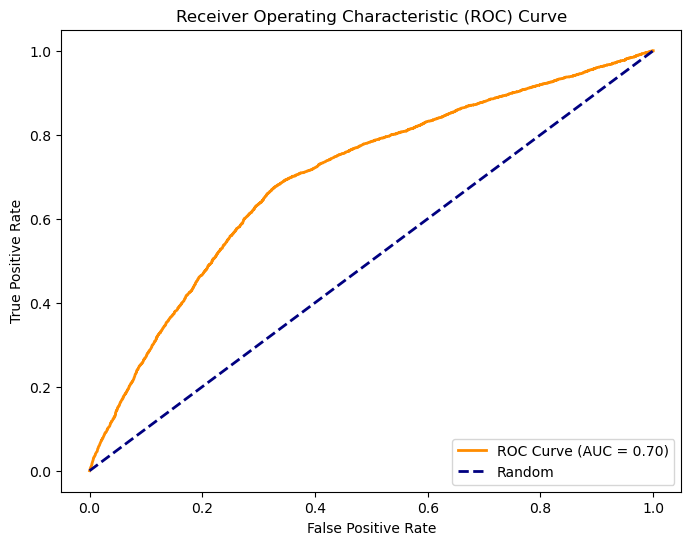

In [424]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [426]:
roc_auc

0.6996693348622903

In [428]:
gini = 2*roc_auc-1
gini

0.39933866972458065

## Métodos solicitados

In [439]:
#pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 13.2 MB/s eta 0:00:000:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [503]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import time

In [443]:
var_predictoras = ['woe_NumCuentas', 'woe_edad', 'woe_IngAn', 'woe_occupation', 'woe_CompPagos']
X_train = dfData2[var_predictoras]
y_train = dfData2[['malo']]
X_test = df_test[var_predictoras]
y_test = df_test[['malo']]

## Árboles de decisión

In [506]:
start_time = time.time()

clf_tree = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")

Tiempo de ejecución: 0.08360838890075684 segundos


- DecisionTreeClassifier(max_depth=5) Máximo niveles de nodos
- DecisionTreeClassifier(min_samples_split=10) Mínimo de muestras necesarias para dividir un nodo interno.
- DecisionTreeClassifier(min_samples_leaf=5) Mínimo de muestras necesarias en un nodo hoja
- DecisionTreeClassifier(criterion="entropy") Criterio de separación

In [544]:
start_time = time.time()


clf_tree_modificado = DecisionTreeClassifier(max_depth=50, min_samples_split=1000, min_samples_leaf=1000, criterion="entropy" ).fit(X_train, y_train)
y_pred_tree_modificado = clf_tree_modificado.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")




Tiempo de ejecución: 0.04182839393615723 segundos


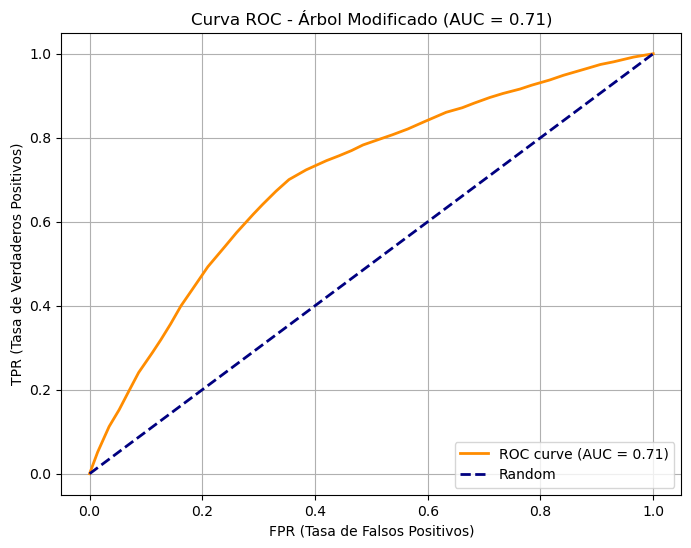

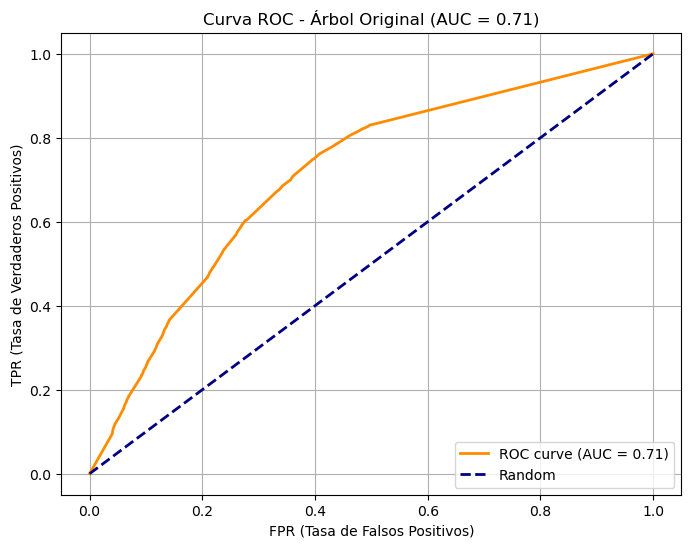

,Model,AUC
0,Árbol Modificado,0.705440
1,Árbol Original,0.710987


In [546]:
modelos_arboles = [(clf_tree_modificado, 'Árbol Modificado'), (clf_tree, 'Árbol Original')]
compare_models_auc(modelos_arboles, X_train, y_train, X_test, y_test)


## Máquinas de Soporte Vectorial


In [449]:
clf_svc = SVC().fit(X_train, y_train) # probability=True
y_pred_svc = clf_svc.predict(X_test)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Random forest

In [451]:
clf_rf = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## XG Boosting

In [455]:
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

/home/d6ee8fac-84aa-4205-9074-fcdc2efb2fd6/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:56:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


##  Análisis discriminante lineal

In [458]:
clf_lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
y_pred_lda = clf_lda.predict(X_test)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## K-vecinos

In [461]:
clf_knn = KNeighborsClassifier().fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Redes Neuronales

In [464]:
clf_nn = MLPClassifier(max_iter=300).fit(X_train, y_train)
y_pred_nn = clf_nn.predict(X_test)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Comparación de los AUC's

In [493]:
print("Precisión de los métodos:")
print("Logit Accuracy:                       ", accuracy_score(y_test, y_pred))
print("Árboles de Decisión Accuracy:", accuracy_score(y_test, y_pred_tree))
#print("SVM Accuracy:               ", accuracy_score(y_test, y_pred_svc))
print("Random Forest Accuracy:      ", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:            ", accuracy_score(y_test, y_pred_xgb))
print("LDA Accuracy:                ", accuracy_score(y_test, y_pred_lda))
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Neural Network Accuracy:     ", accuracy_score(y_test, y_pred_nn))

Precisión de los métodos:
Logit Accuracy:                        0.664842903575298
Árboles de Decisión Accuracy: 0.7181473456121343
Random Forest Accuracy:       0.7158721560130011
XGBoost Accuracy:             0.7294149512459371
LDA Accuracy:                 0.7204767063921993
K-Nearest Neighbors Accuracy: 0.7112134344528711
Neural Network Accuracy:      0.7230769230769231


In [495]:
def calculate_auc(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_name=None):
    # Predecir probabilidades para la clase positiva
    y_prob = model.predict_proba(X_test)[:, 1]  # Se toma la probabilidad de la clase positiva
    
    # Calcular AUC
    auc = roc_auc_score(y_test, y_prob)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')  
    plt.xlabel('FPR (Tasa de Falsos Positivos)')
    plt.ylabel('TPR (Tasa de Verdaderos Positivos)')
    plt.title(f'Curva ROC - {model_name} (AUC = {auc:.2f})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    result = {'Model': model_name if model_name else str(model),
              'AUC': auc}
    
    return result

In [497]:
def compare_models_auc(models, X_train, y_train, X_test, y_test):
    results = []  # Lista para almacenar los resultados
    
    # Calcular el AUC para cada modelo y agregar a la lista
    for model, model_name in models:
        result = calculate_auc(model, X_train, y_train, X_test, y_test, model_name=model_name)
        results.append(result)
    
    # Convertir los resultados en un DataFrame
    df_results = pd.DataFrame(results)
    
    return df_results


In [499]:
models = [
    (clf_tree, "Árbol de Decisión"),
    (clf_rf, "Bosque Aleatorio"),
    #(clf_svc, "Máquina de Soporte Vectorial"),
    (clf_xgb, "XGBoost"),
    (clf_lda, "LDA"),
    (clf_knn, "KNN"),
    (clf_nn, "Red Neuronal")
]


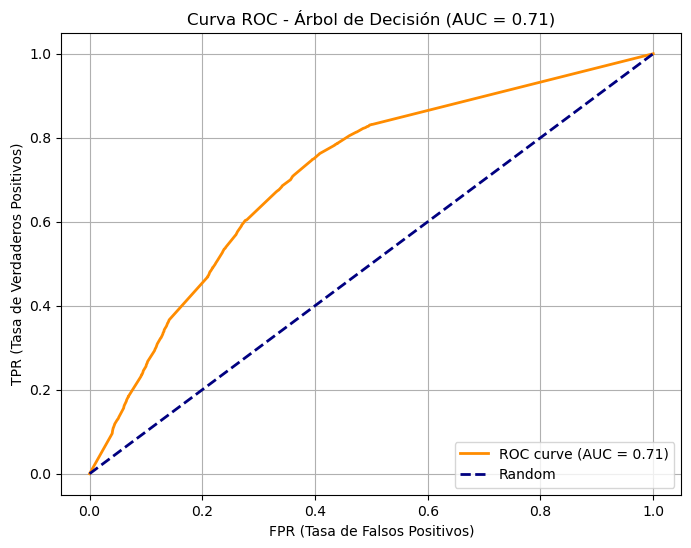

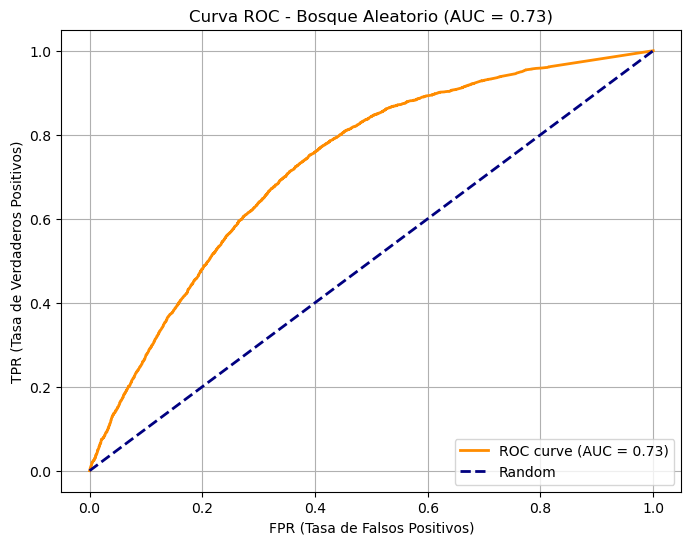

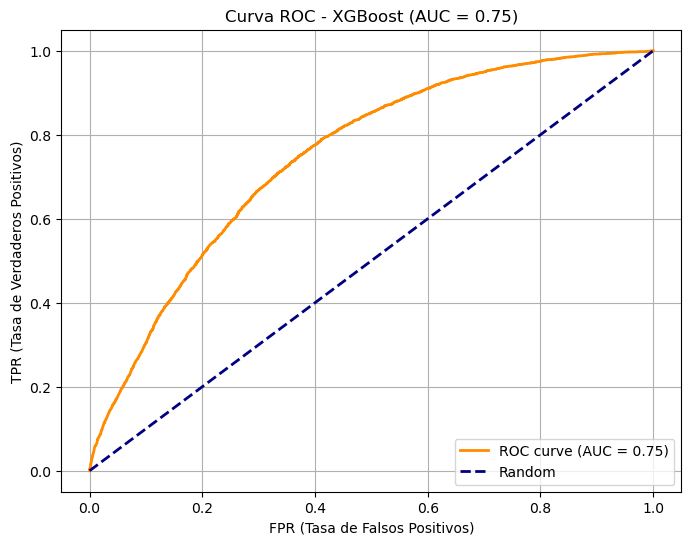

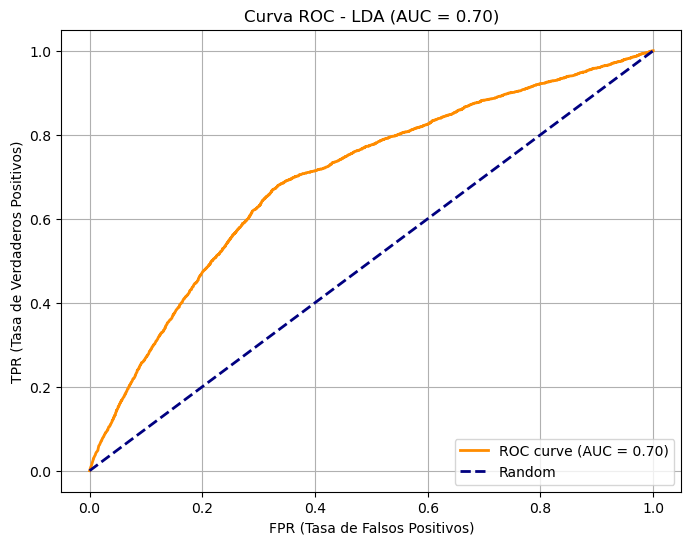

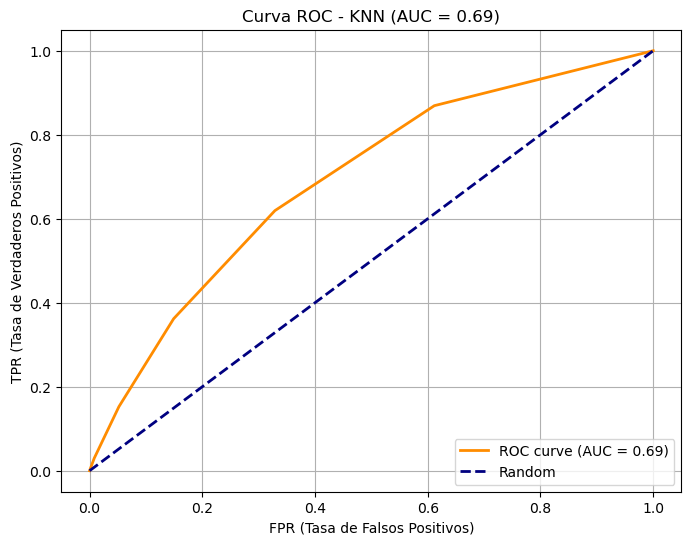

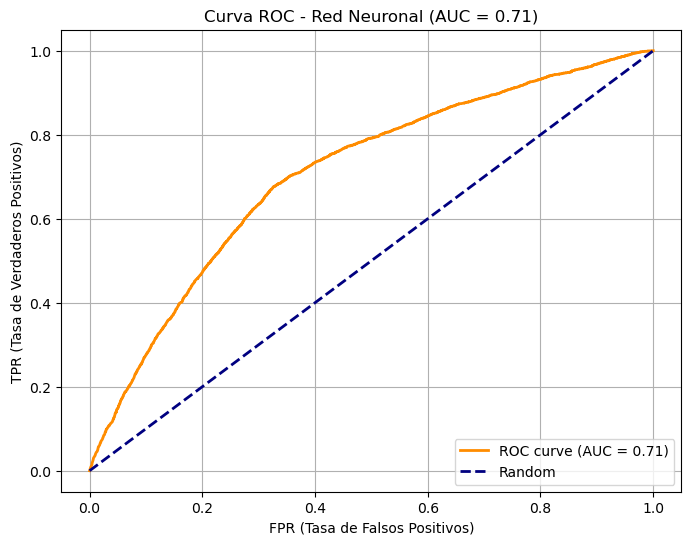

               Model       AUC
0  Árbol de Decisión  0.711300
1   Bosque Aleatorio  0.728281
2            XGBoost  0.748092
3                LDA  0.697440
4                KNN  0.690660
5       Red Neuronal  0.707034


In [501]:
graficas_auc = compare_models_auc(models, X_train, y_train, X_test, y_test)
print(graficas_auc)